# Rating of a Single-Stage Vapor Compression Machine
---

In this notebook, we take off where the design calculations of an air conditioning system have landed. From these design calculations we have: 
- the design state of the air that enters the DX air-cooling coil,
- the desired state of the air at the exit of this air-cooling coil under design conditions,
- the required mass flow rate of air that must flow through the coil and that's being supplied to the zone(s).

**Importing libraries and notebook preparation**

In [1]:
import warnings
from pathlib import Path
from hvac import Quantity
from hvac.fluids import Fluid, HumidAir
from hvac.heat_exchanger.recuperator.fintube.continuous_fin import (
    PlainFinTubeCounterFlowAirEvaporator,
    PlainFinTubeCounterFlowAirCondenser
)
from hvac.vapor_compression import (
    VariableSpeedCompressor,
    SingleStageVaporCompressionMachine
)
from hvac.charts import LogPhDiagram, StandardVaporCompressionCycle

warnings.filterwarnings('ignore', category=UserWarning)

Q_ = Quantity
R410a = Fluid('R410a')

## Preliminary Calculations Solely Based on the Given Air States

**Given**<br>
- the state of air entering the evaporator
- the desired state of air at the exit of the evaporator
- the air mass flow rate through the evaporator
- the state of outdoor air entering the condenser of the cooling machine 

In [2]:
evp_air_in = HumidAir(Tdb=Q_(28.2, 'degC'), W=Q_(10.6, 'g / kg'))
evp_air_out = HumidAir(Tdb=Q_(14.0, 'degC'), W=Q_(9.1, 'g / kg'))
evp_air_m_dot = Q_(10_762.4, 'kg / hr')

To cool the air from the entering state to the leaving state, the heat rate that must be extracted from the air stream follows from: 

In [3]:
evp_Q_dot = evp_air_m_dot * (evp_air_in.h - evp_air_out.h)

print(evp_Q_dot.to('kW'))

54.88492213079321 kilowatt


The refrigerant used in the cooling machine is R410A. We select the evaporation temperature of the refrigerant in the air-cooling coil:

In [4]:
T_evp = Q_(6, 'degC')

The corresponding evaporation pressure is:

In [5]:
evp_rfg_sv = R410a(T=T_evp, x=Q_(1, 'frac'))  # saturated vapor
P_evp = evp_rfg_sv.P

print(P_evp.to('bar'))

9.621405188990046 bar


The state of the outdoor air entering the condenser under design conditions is:

In [6]:
cnd_air_in = HumidAir(Tdb=Q_(32, 'degC'), Twb=Q_(21, 'degC'))

As the air flows through the condenser, its temperature is raised. We select a target value for the temperature rise of the air at the exit of the condenser:

In [7]:
cnd_dT_air = Q_(20, 'K')

We select the condensing temperature of the refrigerant in the condenser:

In [8]:
T_cnd = Q_(60, 'degC')

The corresponding condensation pressure is:

In [9]:
cnd_rfg_sl = R410a(T=T_cnd, x=Q_(0, 'frac'))
P_cnd = cnd_rfg_sl.P

print(P_cnd.to('bar'))

38.426492585552445 bar


We select the degree of refrigerant superheating at the exit of the evaporator, and the degree of subcooling of the refrigerant at the exit of the condenser:

In [10]:
dT_sh = Q_(10, 'K')
dT_sc = Q_(10, 'K')

## Defining the Evaporator

To define the evaporator, we also need the width and height of the frontal area of the evaporator's air inlet. Therefore, we select an appropriate face velocity (the larger the face velocity, the larger the air-side pressure loss across the evaporator and in consequence, the fan power that will be needed to transport the air).

In [11]:
evp_v_fa = Q_(2, 'm / s')

With the selected air face velocity, we can determine the frontal area of the air inlet:

In [12]:
evp_air_V_dot = evp_air_m_dot / evp_air_in.rho
evp_A_fa = evp_air_V_dot / evp_v_fa

print(evp_A_fa.to('m**2'))

1.2973818919086504 meter ** 2


We select the height of the frontal area, and then we can determine its width: 

In [13]:
evp_H_fa = Q_(1, 'm')
evp_W_fa = evp_A_fa / evp_H_fa

print(evp_W_fa.to('m'))

1.2973818919086504 meter


Now we can define the size and the heat exchanger core geometry of the evaporator:

In [14]:
evaporator = PlainFinTubeCounterFlowAirEvaporator(
    W_fro=evp_W_fa,               # width of frontal area
    H_fro=evp_H_fa,               # height of frontal area
    N_rows=4,                     # number of rows
    S_trv=Q_(22.42, 'mm'),        # vertical distance between tubes
    S_lon=Q_(22.27, 'mm'),        # horizontal distance between tubes
    D_int=Q_(8.422, 'mm'),        # inner tube diameter
    D_ext=Q_(10.2, 'mm'),         # outer tube diameter
    t_fin=Q_(0.3302, 'mm'),       # fin thickness
    N_fin=1 / Q_(2.8, 'mm'),      # fin density
    k_fin=Q_(237, 'W / (m * K)')  # conductivity of fin material
)

Initially, we need to guess the number of rows that will be needed.

## Preliminary Rating of the Evaporator

To select the compressor (see below), we need to rate the evaporator. To be able to rate the evaporator, we need to know:
- the state of the air entering the evaporator,
- the mass flow rate of air,
- the degree of refrigerant superheating that will be set on the expansion device of the cooling machine,
- the state of the refrigerant entering the evaporator,
- an initial guess of the refrigerant mass flow rate through the evaporator.

The first three elements were already determined or decided on in the preliminary calculations. To determine the state of the refrigerant entering the evaporator, we need to start in the condenser. We have already selected the condensing temperature (and its corresponding condensing pressure) and the degree of refrigerant subcooling. From this, the state of the refrigerant leaving the condenser can be determined:

In [15]:
cnd_rfg_out = R410a(T=T_cnd.to('K') - dT_sc, P=P_cnd)

print(cnd_rfg_out.T.to('degC'), cnd_rfg_out.h.to('kJ/kg'), cnd_rfg_out.P.to('bar'))

50.0 degree_Celsius 284.0756851222154 kilojoule / kilogram 38.42649258555257 bar


We also have already selected the evaporation temperature and its corresponding evaporation pressure. It is assumed that the pressure in the evaporator is everywhere equal to the evaporation pressure. Since the expansion process can be considered to be an isenthalpic process, we can determine the enthalpy of the refrigerant at the evaporator's inlet. Now, the state of the refrigerant at the evaporator inlet can be determined as:

In [16]:
evp_rfg_in = R410a(h=cnd_rfg_out.h, P=P_evp)

print(evp_rfg_in.T.to('degC'), evp_rfg_in.h.to('kJ/kg'), evp_rfg_in.P.to('bar'), evp_rfg_in.x.to('pct'))

5.931025757011071 degree_Celsius 284.0756851222154 kilojoule / kilogram 9.621405188990046 bar 35.05759009175273 percent


Knowing the evaporation pressure and the degree of refrigerant superheating at the evaporator exit, also the state of the refrigerant leaving the evaporator can be determined:

In [17]:
evp_rfg_out = R410a(T=T_evp.to('K') + dT_sh, P=P_evp)

print(evp_rfg_out.T.to('degC'), evp_rfg_out.h.to('kJ/kg'), evp_rfg_out.P.to('bar'))

16.0 degree_Celsius 434.354299320717 kilojoule / kilogram 9.621405144545614 bar


In the preliminary calculations, we've determined the heat rate that must be extracted from the air stream. This is also the heat rate that must be absorbed by the refrigerant in the evaporator (ignoring any heat transfer from the environment). Knowing the states of the refrigerant at the evaporator's inlet and outlet, and the required cooling capacity of the refrigerant in the evaporator, we can now determine the mass flow rate of refrigerant that is needed to cool the air stream to its desired state:

In [18]:
rfg_m_dot = evp_Q_dot / (evp_rfg_out.h - evp_rfg_in.h)

print(rfg_m_dot.to('kg / hr'))

1314.7959922618563 kilogram / hour


Rating the evaporator means that we want to determine the mass flow rate of refrigerant that is required to superheat the refrigerant at the evaporator exit to the degree set on the expansion device, (1) under the operating conditions being considered, and (2) taking the heat exchanger characteristics of the actual evaporator into account. The refrigerant mass flow rate that we have determined will serve as an initial guess for this.

In [19]:
rfg_m_dot = evaporator.solve(
    air_in=evp_air_in,
    air_m_dot=evp_air_m_dot,
    rfg_in=evp_rfg_in,
    dT_sh=dT_sh,
    rfg_m_dot_ini=rfg_m_dot
)

print(rfg_m_dot.to('kg / hr'))

1534.385512076111 kilogram / hour


The actual state of the air leaving this evaporator under the given operating conditions is:

In [20]:
print(evaporator.air_out)

13.17 °C DB, 8.22 g/kg AH (87 % RH)


The actual heat rate extracted from the air stream and absorbed by the refrigerant is:

In [21]:
print(evaporator.Q_dot.to('kW'))

64.05148011140447 kilowatt


(This is much more than we need as determined in our preliminary calculations. We could try to reduce the number of rows of the evaporator from 4 to 3, but if we do this, the rating routine will raise an exception indicating that it is not possible anymore to attain the set degree of refrigerant superheating.) 

## Selecting and Modeling the Compressor

Using the selection software of a compressor manufacturer, we can select an appropriate compressor based on:
- the cooling capacity that follows from our preliminary rating of the evaporator
- the refrigerant that we have selected,
- the evaporation temperature, the condensing temperature, the degree of superheating, and the degree of subcooling that we have selected.

After downloading the polynomial coefficients for this compressor and preparing the csv-file, we can instantiate the compressor model:

In [22]:
compressor = VariableSpeedCompressor(
    coeff_file=Path('./compressor_data/VZH117CGM_R410a.csv'),
    refrigerant=R410a,
    dT_sh=dT_sh,
    dT_sc=dT_sc,
    units={'m_dot': 'kg / hr', 'n': '1 / s'}
)

Once the compressor model has been created, we can determine the compressor speed that corresponds with the mass flow rate of refrigerant through the evaporator:

In [23]:
# Set the selected evaporation and condensing temperature:
compressor.T_evp = T_evp
compressor.T_cnd = T_cnd

# Determine the compressor speed based on the refrigerant mass flow
# rate determined when rating the evaporator:
n_cmp = compressor.compressor_speed(m_dot=rfg_m_dot)

print(n_cmp.to('1 / min'))

6705.5005495583355 / minute


## Defining the Condenser

To determine the frontal area of the condenser, we first need to determine the mass flow rate of air through the condenser. For this, we need to know the rate at which heat must be rejected to the air in the condenser. This heat rejection rate is the sum of the heat rate absorbed by the refrigerant in the evaporator and the mechanical power that the compressor delivers to the refrigerant to transport it from the low to the high-pressure zone. To determine the compressor power, we must still set the compressor speed we determined above on the compressor model:

In [24]:
compressor.speed = n_cmp
cnd_Q_dot = evaporator.Q_dot + compressor.W_dot

print(cnd_Q_dot.to('kW'))

89.38608884946107 kilowatt


The state of the air leaving the condenser follows from our preliminary calculations:

In [25]:
cnd_air_out = HumidAir(
    Tdb=cnd_air_in.Tdb.to('K') + cnd_dT_air,
    W=cnd_air_in.W  # heating is always a sensible process
)

The mass flow rate of air through the condenser:

In [26]:
cnd_air_m_dot = cnd_Q_dot / (cnd_air_out.h - cnd_air_in.h)

print(cnd_air_m_dot.to('kg / hr'))

15652.037109519977 kilogram / hour


As with the evaporator, we select an air face velocity:

In [27]:
cnd_v_fa = Q_(1.5, 'm / s')

With the selected air face velocity, we can determine the frontal area of the air inlet:

In [28]:
cnd_air_V_dot = cnd_air_m_dot / cnd_air_in.rho
cnd_A_fa = cnd_air_V_dot / cnd_v_fa
cnd_H_fa = Q_(1.5, 'm')
cnd_W_fa = cnd_A_fa / cnd_H_fa

print(cnd_A_fa.to('m**2'))
print(cnd_W_fa.to('m'))

2.5496150647910576 meter ** 2
1.6997433765273715 meter


In [29]:
condenser = PlainFinTubeCounterFlowAirCondenser(
    W_fro=cnd_W_fa,               # width of frontal area
    H_fro=cnd_H_fa,               # height of frontal area
    N_rows=4,                     # number of rows
    S_trv=Q_(22.42, 'mm'),        # vertical distance between tubes
    S_lon=Q_(22.27, 'mm'),        # horizontal distance between tubes
    D_int=Q_(8.422, 'mm'),        # inner tube diameter
    D_ext=Q_(10.2, 'mm'),         # outer tube diameter
    t_fin=Q_(0.3302, 'mm'),       # fin thickness
    N_fin=1 / Q_(2.8, 'mm'),      # fin density
    k_fin=Q_(237, 'W / (m * K)')  # conductivity of fin material
)

## Defining the Cooling Machine

After defining the main parts of the cooling machine, we can define the cooling machine's model: 

In [30]:
vcm = SingleStageVaporCompressionMachine(
    evaporator, condenser, compressor, R410a,
    dT_sh=dT_sh,
    n_cmp_min=Q_(1500, '1 / min'),
    n_cmp_max=Q_(6000, '1 / min')
)

## Rating the Cooling Machine

To determine the performance of the cooling machine, we'll use a different approach than that we've used in the previous notebook *ex05_vcm_rating.ipynb*. Here, we want to determine the compressor speed of the variable speed compressor so that the selected evaporation and condensing temperature will be established under the given operating conditions.

In [31]:
output = vcm.balance_by_speed(
    evp_air_in=evp_air_in,
    evp_air_m_dot=evp_air_m_dot,
    cnd_air_in=cnd_air_in,
    cnd_air_m_dot=cnd_air_m_dot,
    T_evp=T_evp,
    T_cnd=T_cnd
)

print(output.to_text())

[24236 | hvac.vapor_compression.machine | INFO] Starting speed balancing with...
[24236 | hvac.vapor_compression.machine | INFO] evp_air_in: 28.20 °C, 44 %
[24236 | hvac.vapor_compression.machine | INFO] evp_air_m_dot: 10762.40 kg/h
[24236 | hvac.vapor_compression.machine | INFO] cnd_air_in: 32.00 °C, 37 %
[24236 | hvac.vapor_compression.machine | INFO] cnd_air_m_dot: 15652.04 kg/h
[24236 | hvac.vapor_compression.machine | INFO] T_evp = 6.00 °C
[24236 | hvac.vapor_compression.machine | INFO] T_cnd = 60.00 °C
[24236 | hvac.vapor_compression.machine | INFO] Iteration 1: Try with: 1500.000 rpm
[24236 | hvac.vapor_compression.machine | INFO] Iteration 1: Refrigerant mass flow rate from compressor = 328.241 kg/h
[24236 | hvac.vapor_compression.machine | INFO] Iteration 1: Refrigerant entering condenser with T = 110.804 °C, P = 38.348 bar
[24236 | hvac.vapor_compression.machine | INFO] Iteration 1: Refrigerant leaving condenser with T = 34.895 °C, P = 38.348 bar
[24236 | hvac.vapor_compressi

evp_air_m_dot = 10762.400 kg/h
cnd_air_m_dot = 15652.037 kg/h
evp_air_in = 28.200 °C DB, 10.600 g/kg AH (44 % RH)
cnd_air_in = 32.000 °C DB, 11.111 g/kg AH (37 % RH)
n_cmp = 5207.044 1/min
dT_sh = 10.000 K
evp_air_out = 14.072 °C DB, 8.703 g/kg AH (87 % RH)
cnd_air_out = 49.264 °C DB, 11.111 g/kg AH (15 % RH)
evp_Q_dot = 57.634 kW
cnd_Q_dot = 77.037 kW
cmp_W_dot = 19.404 kW
rfg_m_dot = 1196.520 kg/h
COP = 3.970 frac
EER = 2.970 frac
evp_eps = 0.5289 frac
cnd_eps = 0.4784 frac
T_evp = 6.000 °C
P_evp = 9.621 bar
T_cnd = 59.907 °C
P_cnd = 38.348 bar
dT_sc = 22.004 K
suction_gas = 16.000 °C, 434.354 kJ/kg, 9.621 bar
discharge_gas = 105.337 °C, 492.735 kJ/kg, 38.348 bar
liquid = 37.903 °C, 260.950 kJ/kg, 38.348 bar
mixture = 5.920 °C, 260.950 kJ/kg, 9.621 bar, 24 %
evp_air_dP = 51.657 Pa
cnd_air_dP = 35.820 Pa


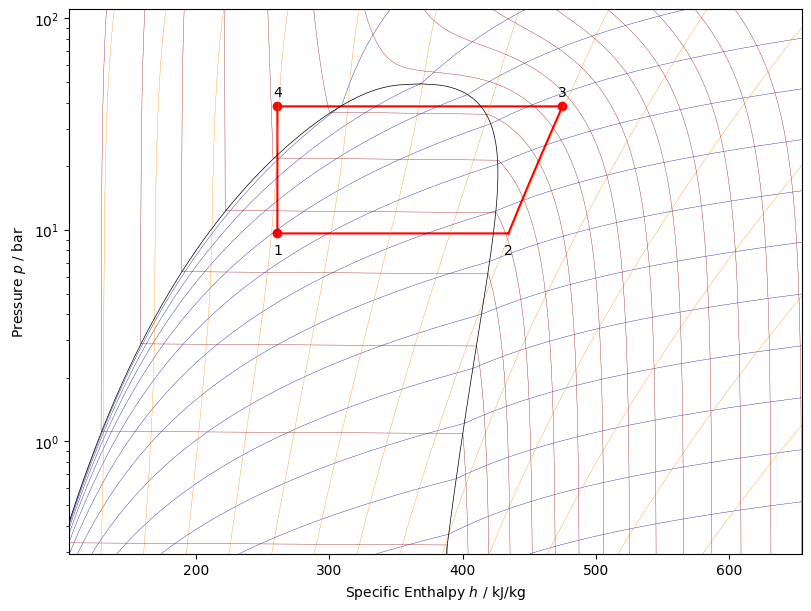

In [32]:
cycle = StandardVaporCompressionCycle(
    Refrigerant=R410a,
    evaporationTemperature=output.T_evp,
    condensationTemperature=output.T_cnd,
    evaporatorSuperheat=output.dT_sh,
    subCooling=output.dT_sc
)

log_ph_diagram = LogPhDiagram(R410a, size=(8, 6))
log_ph_diagram.setCycle(cycle)
log_ph_diagram.show()